In [1]:
from dreams.utils.data import MSData
import numpy as np
import pandas as pd
from dreams.api import dreams_embeddings
from sklearn.metrics.pairwise import cosine_similarity
import umap
from dreams.utils.mols import formula_type
import seaborn as sns
import matplotlib.pyplot as plt
from dreams.utils.plots import init_plotting
from matplotlib.colors import LinearSegmentedColormap

In [2]:
data_full = MSData.from_mgf('data/mgf_MoNA_experimental.mgf', in_mem=False)
print(data_full)
print(data_full.columns())

MSData(pth=data\mgf_MoNA_experimental.hdf5, in_mem=False) with 167,958 spectra.
['EXACTMASS', 'FORMULA', 'INCHIKEY', 'INSTRUMENT_TYPE', 'IONMODE', 'NAME', 'RTINSECONDS', 'SOURCE_INSTRUMENT', 'SPECTRUM_TYPE', 'charge', 'precursor_mz', 'smiles', 'spectrum']


### Get meaningful subset of dataset

- ASSUMPTION: SPECTRUM_TYPE representative of the dataset
- some datapoints do not have a SPECTRUM_TYPE. Why?

- dataset is too large -> proportional subsampling on SPECTRUM_TYPE

Spectrum Types and their counts:
: 12643
MS1: 18591
MS2: 134158
MS2-MS2 Composite: 38
MS2-MS3 Composite: 313
MS2-MS4 Composite: 509
MS2-MS5 Composite: 1020
MS3: 635
MS4: 50
MS5: 1
Total sampled indices: 10000
Print 3 random samples (sanity check):


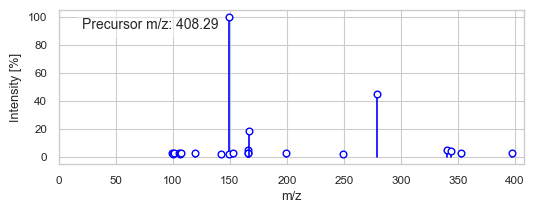

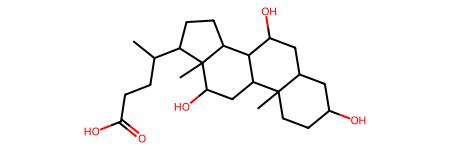

{'EXACTMASS': 408.28757437999997, 'FORMULA': 'C24H40O5', 'INCHIKEY': 'BHQCQFFYRZLCQQ-OELDTZBJSA-N', 'INSTRUMENT_TYPE': '', 'IONMODE': 'P', 'NAME': 'CholicAcid', 'RTINSECONDS': '', 'SOURCE_INSTRUMENT': 'Orbitrap', 'SPECTRUM_TYPE': '', 'charge': 'M-H2O+H', 'precursor_mz': 408.28757437999997, 'smiles': 'CC(CCC(=O)O)C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)O)C)O)O)C'}


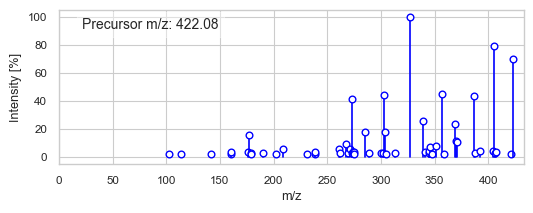

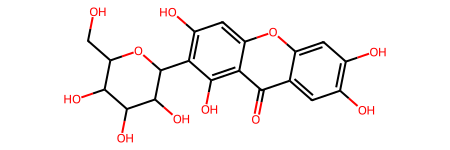

{'EXACTMASS': 422.084911396, 'FORMULA': 'C19H18O11', 'INCHIKEY': 'AEDDIBAIWPIIBD-ZJKJAXBQSA-N', 'INSTRUMENT_TYPE': 'LC-ESI-QTOF', 'IONMODE': 'P', 'NAME': 'Mangiferin', 'RTINSECONDS': '', 'SOURCE_INSTRUMENT': 'Agilent 6530 Q-TOF', 'SPECTRUM_TYPE': 'MS2', 'charge': '[M+H]+', 'precursor_mz': 422.084911396, 'smiles': 'O=C1C2=CC(O)=C(O)C=C2OC3=CC(O)=C(C(O)=C13)C4OC(CO)C(O)C(O)C4O'}


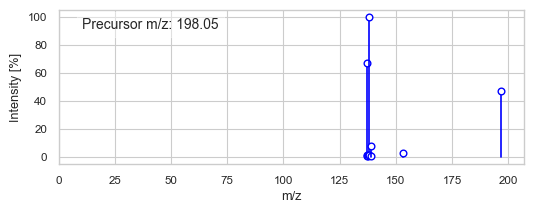

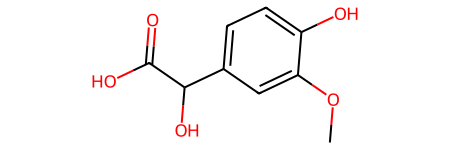

{'EXACTMASS': 198.05282341999998, 'FORMULA': 'C9H10O5', 'INCHIKEY': 'CGQCWMIAEPEHNQ-UHFFFAOYSA-N', 'INSTRUMENT_TYPE': 'LC-ESI-QTOF', 'IONMODE': 'N', 'NAME': '4-HYDROXY-3-METHOXYMANDELIC ACID', 'RTINSECONDS': '', 'SOURCE_INSTRUMENT': 'Agilent qTOF 6545', 'SPECTRUM_TYPE': 'MS2', 'charge': '[M-H]-', 'precursor_mz': 198.05282341999998, 'smiles': 'O=C(O)C(O)C1=CC=C(O)C(OC)=C1'}

Sampled dataset saved!



In [3]:
# there are 10 unique SPECTRUM_TYPE for 167,958 spectra

spectrum_types = data_full['SPECTRUM_TYPE']
spectrum_types = np.array(spectrum_types)
unique_types, type_counts = np.unique(spectrum_types, return_counts=True)

print("Spectrum Types and their counts:")
for type, count in zip(unique_types, type_counts):
    print(f"{type}: {count}")


type_proportions = type_counts / len(spectrum_types)
# embedding takes approx. 1h for 20k embeddings on local machine
total_samples = 10000
samples_per_type = np.round(type_proportions * total_samples).astype(int)

sampled_indices = []

for spectrum_type, n_samples in zip(unique_types, samples_per_type):
    type_indices = np.where(spectrum_types == spectrum_type)[0]
    
    # If we have fewer spectra of this type than we want to sample, take all of them
    if len(type_indices) <= n_samples:
        sampled_indices.extend(type_indices)
    else:
        sampled_indices.extend(np.random.choice(type_indices, size=n_samples, replace=False))

# Ensure we have exactly 10000 samples
sampled_indices = sampled_indices[:total_samples]
sampled_spectra = data_full.get_spectra()[sampled_indices]
print(f"Total sampled indices: {len(sampled_indices)}")
print("Print 3 random samples (sanity check):")
print_indices = np.random.choice(sampled_indices, size=3, replace=False)
for i in print_indices:
    print(data_full.at(i))

data_short = data_full.form_subset(sampled_indices, "data/MoNA_experimental_short.hdf5")
print("\nSampled dataset saved!\n")


### Using pre-trained DreaMS embedding model

In [4]:

# use pretrained embedding model
dreams_embs = dreams_embeddings("data/MoNA_experimental_short.hdf5")


Computing DreaMS embedding: 100%|██████████| 10000/10000 [29:03<00:00,  5.73it/s]


In [5]:
sims = cosine_similarity(dreams_embs)

### Proposed novelty score:

Inverse average cosine similarity of spectrum i against the whole subset

### Explanation:
If a spectrum is similar to many points of the subset, it must mean that it is not really unique, so it should get a low novelty score. Analogously, a datapoint is considered novel if it is different from most points of the dataset.

In [6]:
novelty_scores = [1-np.mean(s) for s in sims]

In [ ]:
# convert to pandas for ease of operations
pd_short = data_short.to_pandas()
pd_short["original_index"] = sampled_indices
pd_short["NOVELTY_SCORE"] = novelty_scores
pd_short["DREAMS_EMBEDDING"] = dreams_embs.tolist()

#convert back to MSData and save as hdf5
data = MSData.from_pandas(pd_short, hdf5_pth="data/MoNA_experimental_short_annotated.hdf5")

In [10]:
# write a list of indices and novelty scores
results = pd.DataFrame()
results["index"] = pd_short["original_index"]
results["NOVELTY_SCORE"] = pd_short["NOVELTY_SCORE"]
results.to_csv("data/results.csv", index=False)

### UMAP projection for qualitative confirmation of novelty measure

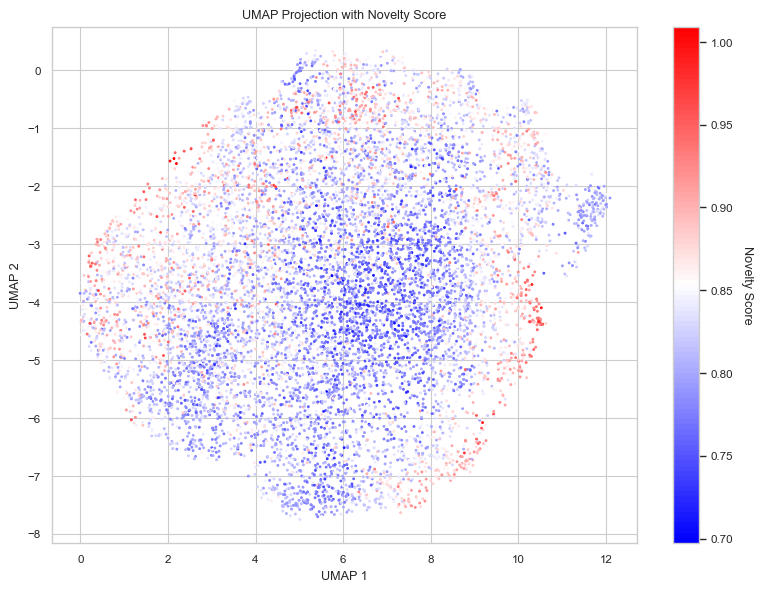

In [11]:
reducer = umap.UMAP(metric='cosine', min_dist=0.4, n_neighbors=50)
embs_umap = reducer.fit_transform(np.array(pd_short["DREAMS_EMBEDDING"].to_list()))

colors = ["blue", "white", "red"]
n_bins = 100
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

# Set up the plot
plt.figure(figsize=(8, 6))

# Create the scatter plot
scatter = plt.scatter(
    x=embs_umap[:, 0],
    y=embs_umap[:, 1],
    c=pd_short["NOVELTY_SCORE"],
    cmap=cmap,
    alpha=1,
    s=1.6
)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Novelty Score", rotation=270, labelpad=15)

# Set labels and title
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Projection with Novelty Score")

# Show the plot
plt.tight_layout()
plt.show()